# Session 6:
## Target: 
Run below versions for 25 epochs and report findings:<br>
with L1 + BN <br>
with L2 + BN <br>
with L1 and L2 with BN <br>
with GBN <br>
with L1 and L2 with GBN <br>

## Results:
Parameters: 8786 <br>
Base Model NLL with BN (Batch size 128) - Train Accuracy / Test Accuracy:  98.72% (max 98.79%) / 99.51% (max 99.53%) <br>
with L1 + BN (Batch size 128) - Train Accuracy / Test Accuracy:  98.78% (max 98.83%) / 99.42% (max 99.43%) <br>
with L2 + BN (Batch size 128) - Train Accuracy / Test Accuracy: 98.77% (max 98.79%) / 99.36% (max 99.38%) <br>
with L1 and L2 with BN (Batch size 128) - Train Accuracy / Test Accuracy: 98.77% (max 98.80%) / 99.42% (max 99.45%) <br>
with GBN (Batch size 512) - Train Accuracy / Test Accuracy: 98.3 (max 98.3) / 99.23 (max 99.24) <br>
with L1 and L2 with GBN (Batch size 512) - Train Accuracy / Test Accuracy: 98.34% (max 98.34%) / 99.18% (max 99.20%) <br>

## Analysis: <br>
- L1 Regularization reduces the gap between train and test accuracies, in this case train accuracy increased and test accuracy decreased. As expected from regularization. <br>

- L2 Regularization reduces the gap between train and test accuracies, in this case train accuracy increased and test accuracy decreased. As expected from regularization. <br>

- L1+L2 regularisation seems to give better results, with test accuracy also increasing while the gap between train and test reduced.

- For L1+L2 with / without GBN, it is seen that Ghost Batch normalisation seems to reduce the gap between train and test accuracy, in this case increased the train accuracy but decreased the test accuracy. <br>
However, if we look NLL + BN and NLL + GBN comparison, NLL + BN gives higher train and test accuracy. <br>


# Import Libraries

In [1]:
# importing all the Python Packages & torch Library.
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Define Data Transformations & Dataset for Train/Test

In [2]:
train_transforms = transforms.Compose([
                        transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
                        # transforms.RandomErasing(),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])

test_transforms = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])

train_data = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Train / Test Dataloaders

In [3]:
# seed the model to obtain consistent results
torch.manual_seed(1)
# this is the batch size , in 1 pas no of images passed together.
batch_size = 128
num_splits = 2
use_cuda = torch.cuda.is_available()

print("CUDA Available?", use_cuda)

# kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}

# dataloader arguments - something you'll fetch these from cmdprmt
# dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True) if use_cuda else dict(shuffle=True, batch_size=int(batch_size/2))



# load the training data and perform standard normalization 
# parameter for normalization is mean and std dev.
# train dataloader
# train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
# test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Ghost Batch Normalisation

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class GhostBatchNorm(nn.BatchNorm2d):
    """
    From : https://github.com/davidcpage/cifar10-fast/blob/master/bag_of_tricks.ipynb

    Batch norm seems to work best with batch size of around 32. The reasons presumably have to do 
    with noise in the batch statistics and specifically a balance between a beneficial regularising effect 
    at intermediate batch sizes and an excess of noise at small batches.
    
    Our batches are of size 512 and we can't afford to reduce them without taking a serious hit on training times, 
    but we can apply batch norm separately to subsets of a training batch. This technique, known as 'ghost' batch 
    norm, is usually used in a distributed setting but is just as useful when using large batches on a single node. 
    It isn't supported directly in PyTorch but we can roll our own easily enough.
    """
    def __init__(self, num_features, num_splits, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super(GhostBatchNorm, self).__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias        
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features*self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features*self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(self.num_splits)
        return super(GhostBatchNorm, self).train(mode)
        
    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C*self.num_splits, H, W), self.running_mean, self.running_var, 
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W) 
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features], 
                self.weight, self.bias, False, self.momentum, self.eps)



# The Model

In [5]:
class Net(nn.Module):
    def __init__(self, batchnorm):
        super(Net, self).__init__()
        
        if (batchnorm == "GBN"):
          self.conv1 = nn.Sequential(
              
              nn.Conv2d(in_channels=1, out_channels=4, kernel_size=(3, 3), padding=0, bias = True), # output 26X26X4 : RF- 3X3
              nn.ReLU(),
              GhostBatchNorm(4, num_splits, weight=False), # Ghost Batch Normalization after each convolution.
              nn.Dropout2d(0.05), # dropout of 5% at each layer
              
              nn.Conv2d(4, 8, 3), # output 24X24X8 : RF - 5x5
              nn.ReLU(),
              GhostBatchNorm(8, num_splits, weight=False),  
              nn.Dropout2d(0.05),  # dropout of 5% at each layer

              nn.Conv2d(8, 16, 3), # output 22X22X16 : RF - 7X7
              nn.ReLU(),
              GhostBatchNorm(16, num_splits, weight=False),  
              nn.Dropout2d(0.05),  # dropout of 5% at each layer

              nn.MaxPool2d(2, 2)       # output 11X11X16 : RF - 8x8 
              )
          self.conv2 = nn.Sequential(
              
            
              nn.Conv2d(16, 16, 3), # output 9X9X16 : RF - 12x12
              nn.ReLU(),
              GhostBatchNorm(16, num_splits, weight=False),
              nn.Dropout2d(0.05), # 5% dropout

              nn.Conv2d(16, 16, 3, padding=1), # output 9X9X16 : RF - 16x16
              nn.ReLU(),
              GhostBatchNorm(16, num_splits, weight=False),
              nn.Dropout2d(0.05), # 5% dropout

              )
          self.conv3 = nn.Sequential(
            
              nn.Conv2d(16, 16, 3,padding=1), # output 9X9X16 : RF - 20 X 20
              nn.ReLU(),
              GhostBatchNorm(16, num_splits, weight=False),
              nn.Dropout2d(0.05), # 5% dropout

              nn.Conv2d(16, 10, 1), # output 7X7X10 : RF- 20 X 20
              nn.AvgPool2d(7) # output 1x1x10 : RF - 32x32

              )
        else: # batchnorm == "BN"
          self.conv1 = nn.Sequential(
              
              nn.Conv2d(in_channels=1, out_channels=4, kernel_size=(3, 3), padding=0, bias = True), # output 26X26X4 : RF- 3X3
              nn.ReLU(),
              nn.BatchNorm2d(4), # Batch Normalization after each convolution.
              nn.Dropout2d(0.05), # dropout of 5% at each layer
              
              nn.Conv2d(4, 8, 3), # output 24X24X8 : RF - 5x5
              nn.ReLU(),
              nn.BatchNorm2d(8),  # Batch Normalization after each convolution.
              nn.Dropout2d(0.05),  # dropout of 5% at each layer

              nn.Conv2d(8, 16, 3), # output 22X22X16 : RF - 7X7
              nn.ReLU(),
              nn.BatchNorm2d(16),  # Batch Normalization after each convolution.
              nn.Dropout2d(0.05),  # dropout of 5% at each layer

              nn.MaxPool2d(2, 2)       # output 11X11X16 : RF - 8x8 
              )
          self.conv2 = nn.Sequential(
              
            
              nn.Conv2d(16, 16, 3), # output 9X9X16 : RF - 12x12
              nn.ReLU(),
              nn.BatchNorm2d(16),
              nn.Dropout2d(0.05), # 5% dropout

              nn.Conv2d(16, 16, 3, padding=1), # output 9X9X16 : RF - 16x16
              nn.ReLU(),
              nn.BatchNorm2d(16),
              nn.Dropout2d(0.05), # 5% dropout

              )
          self.conv3 = nn.Sequential(
            
              nn.Conv2d(16, 16, 3,padding=1), # output 9X9X16 : RF - 20 X 20
              nn.ReLU(),
              nn.BatchNorm2d(16),
              nn.Dropout2d(0.05), # 5% dropout

              nn.Conv2d(16, 10, 1), # output 7X7X10 : RF- 20 X 20
              nn.AvgPool2d(7) # output 1x1x10 : RF - 32x32

              )

    def forward(self, x):
        
        x = self.conv1(x)
        x= self.conv2(x)
        x= self.conv3(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, -1)

# Print Summary of Model

In [6]:
!pip install torchsummary
from torchsummary import summary
device = torch.device("cuda" if use_cuda else "cpu")
model = Net("GBN").to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 26, 26]              40
              ReLU-2            [-1, 4, 26, 26]               0
    GhostBatchNorm-3            [-1, 4, 26, 26]               8
         Dropout2d-4            [-1, 4, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             296
              ReLU-6            [-1, 8, 24, 24]               0
    GhostBatchNorm-7            [-1, 8, 24, 24]              16
         Dropout2d-8            [-1, 8, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           1,168
             ReLU-10           [-1, 16, 22, 22]               0
   GhostBatchNorm-11           [-1, 16, 22, 22]              32
        Dropout2d-12           [-1, 16, 22, 22]               0
        MaxPool2d-13           [-1, 16, 11, 11]               0
           Conv2d-14             [-1, 1

# Define Train and Test functions

In [7]:
from tqdm import tqdm
from torch.autograd import Variable

train_losses = []
test_losses = []
train_acc = []
test_acc = []
l1_factor = 0.00001


  # Function to train 
'''
  Args: 
  Model : created model to be used for training
  device : GPU or cpu
  train_laoded: data on which the training has to be done
  Optimizer : the optimization algorithm to be used
  epoch : no fo epoch 

'''
def train(model, device, train_loader, optimizer, epoch, losstype):
    model.train() # Set the model on training mode
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    cross_entropy = nn.CrossEntropyLoss().to(device)


    for batch_idx, (data, target) in enumerate(pbar):
      data, target = data.to(device), target.to(device) # moving the data to device
      optimizer.zero_grad() # zero the graidents 
      output = model(data) # getting the model output

      loss = 0
      if (losstype == "nll") or (losstype == "L2"):
        loss = F.nll_loss(output, target) # calculating the The negative log likelihood loss
      elif (losstype == "L1") or (losstype == "L1L2"):
        # print ("In Train, losstype = L1 / L1L2")
        # Calculate loss
        # loss = F.nll_loss(y_pred, target)
        loss = cross_entropy(output, target)
        # l1_crit = nn.L1Loss(reduce=False)
        reg_loss = 0
        for param in model.parameters():
            reg_loss += torch.sum(abs(param))

        loss += l1_factor * reg_loss

      train_losses.append(loss)
      loss.backward() # flowing the gradients backward.
      optimizer.step() # paameter updated basd on the current gradient.
      
      pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      processed += len(data)        
      
      pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx} Train Accuracy={100*correct/processed:0.2f}')
      train_acc.append(100*correct/processed)
    return train_losses, train_acc

  # Function to test 
'''
  Args: 
  Model : created model to be used for training
  device : GPU or cpu
  test_laoded: data on which the testing has to be done
  

'''
def test(model, device, test_loader): #, losstype):
  model.eval() # seting up the model for evalaution.
  test_loss = 0 # setting the test loss to 0
  correct = 0 # countign the no of coorect classfication.
  with torch.no_grad(): # turn off gradients, since we are in test mode
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)   # copy the data to device.
        output = model(data) # predict the output

        test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset) # calculating the test loss.
  test_losses.append(test_loss)

  print('\nTest set: Average loss: {:.4f}, Test Accuracy: {}/{} ({:.2f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
  test_acc.append(100. * correct / len(test_loader.dataset))
  return test_losses, test_acc

In [8]:
def getmisclassifiedImage(model, device, test_loader):
  misclassified = []
  misclassified_pred = []
  misclassified_target = []
  misclassfiled_list = []
  model.eval()

  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
     
      output = model(data)
      pred = output.argmax(dim =1, keepdim =True)
      
      list_misclassified = (pred.eq(target.view_as(pred)) == False)
      batch_misclassified = data[list_misclassified]
      batch_mis_pred = pred[list_misclassified]
      batch_mis_target = target.view_as(pred)[list_misclassified]

      misclassified.append(batch_misclassified)
      misclassified_pred.append(batch_mis_pred)
      misclassified_target.append(batch_mis_target)
                                  
  # group all the batched together
  
  misclassified = torch.cat(misclassified)
  misclassified_pred = torch.cat(misclassified_pred)
  misclassified_target = torch.cat(misclassified_target)  
                                
 
  misclassfiled_list.append(misclassified)
  misclassfiled_list.append(misclassified_pred)
  misclassfiled_list.append(misclassified_pred)

  return list(map(lambda x, y, z: (x, y, z), misclassified, misclassified_pred, misclassified_target))


In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
def Plot_misclassifed(model, device, test_loader):
 plt.style.use("dark_background")
 misclassified = getmisclassifiedImage(model, device, test_loader)
 num_images = 25
 fig = plt.figure(figsize=(12, 12))
 for idx, (image, pred, target) in enumerate(random.choices(misclassified, k=num_images)):
     image, pred, target = image.cpu().numpy(), pred.cpu(), target.cpu()
     ax = fig.add_subplot(5, 5, idx+1)
     ax.axis('off')
     ax.set_title('target {}\npred {}'.format(target.item(), pred.item()), fontsize=12)
     ax.imshow(image.squeeze())
 plt.show()

# Run the model

  0%|          | 0/469 [00:00<?, ?it/s]

Approach: Loss, BN =  nll BN epoch = 1


loss=0.18689189851284027 batch_id=468 Train Accuracy=90.54: 100%|██████████| 469/469 [00:13<00:00, 33.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0481, Test Accuracy: 9861/10000 (98.61%)

Approach: Loss, BN =  nll BN epoch = 2


loss=0.04215162992477417 batch_id=468 Train Accuracy=96.92: 100%|██████████| 469/469 [00:14<00:00, 33.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0468, Test Accuracy: 9870/10000 (98.70%)

Approach: Loss, BN =  nll BN epoch = 3


loss=0.03562098369002342 batch_id=468 Train Accuracy=97.48: 100%|██████████| 469/469 [00:13<00:00, 33.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0339, Test Accuracy: 9893/10000 (98.93%)

Approach: Loss, BN =  nll BN epoch = 4


loss=0.10883014649152756 batch_id=468 Train Accuracy=97.81: 100%|██████████| 469/469 [00:13<00:00, 33.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Test Accuracy: 9923/10000 (99.23%)

Approach: Loss, BN =  nll BN epoch = 5


loss=0.0788092166185379 batch_id=468 Train Accuracy=97.99: 100%|██████████| 469/469 [00:13<00:00, 33.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Test Accuracy: 9908/10000 (99.08%)

Approach: Loss, BN =  nll BN epoch = 6


loss=0.057114820927381516 batch_id=468 Train Accuracy=98.06: 100%|██████████| 469/469 [00:13<00:00, 33.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Test Accuracy: 9919/10000 (99.19%)

Approach: Loss, BN =  nll BN epoch = 7


loss=0.006530730053782463 batch_id=468 Train Accuracy=98.49: 100%|██████████| 469/469 [00:13<00:00, 34.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Test Accuracy: 9950/10000 (99.50%)

Approach: Loss, BN =  nll BN epoch = 8


loss=0.054726239293813705 batch_id=468 Train Accuracy=98.59: 100%|██████████| 469/469 [00:13<00:00, 33.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Test Accuracy: 9947/10000 (99.47%)

Approach: Loss, BN =  nll BN epoch = 9


loss=0.12413019686937332 batch_id=468 Train Accuracy=98.61: 100%|██████████| 469/469 [00:13<00:00, 34.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Test Accuracy: 9948/10000 (99.48%)

Approach: Loss, BN =  nll BN epoch = 10


loss=0.058394934982061386 batch_id=468 Train Accuracy=98.64: 100%|██████████| 469/469 [00:13<00:00, 34.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Test Accuracy: 9946/10000 (99.46%)

Approach: Loss, BN =  nll BN epoch = 11


loss=0.12215068936347961 batch_id=468 Train Accuracy=98.75: 100%|██████████| 469/469 [00:13<00:00, 34.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Test Accuracy: 9946/10000 (99.46%)

Approach: Loss, BN =  nll BN epoch = 12


loss=0.0814482793211937 batch_id=468 Train Accuracy=98.68: 100%|██████████| 469/469 [00:13<00:00, 33.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Test Accuracy: 9948/10000 (99.48%)

Approach: Loss, BN =  nll BN epoch = 13


loss=0.0013519927160814404 batch_id=468 Train Accuracy=98.74: 100%|██████████| 469/469 [00:13<00:00, 34.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Test Accuracy: 9947/10000 (99.47%)

Approach: Loss, BN =  nll BN epoch = 14


loss=0.039838675409555435 batch_id=468 Train Accuracy=98.71: 100%|██████████| 469/469 [00:13<00:00, 33.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Test Accuracy: 9950/10000 (99.50%)

Approach: Loss, BN =  nll BN epoch = 15


loss=0.02562078833580017 batch_id=468 Train Accuracy=98.75: 100%|██████████| 469/469 [00:13<00:00, 34.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Test Accuracy: 9951/10000 (99.51%)

Approach: Loss, BN =  nll BN epoch = 16


loss=0.04664911329746246 batch_id=468 Train Accuracy=98.77: 100%|██████████| 469/469 [00:13<00:00, 34.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Test Accuracy: 9949/10000 (99.49%)

Approach: Loss, BN =  nll BN epoch = 17


loss=0.017479317262768745 batch_id=468 Train Accuracy=98.71: 100%|██████████| 469/469 [00:13<00:00, 33.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Test Accuracy: 9949/10000 (99.49%)

Approach: Loss, BN =  nll BN epoch = 18


loss=0.07104865461587906 batch_id=468 Train Accuracy=98.77: 100%|██████████| 469/469 [00:13<00:00, 33.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Test Accuracy: 9953/10000 (99.53%)

Approach: Loss, BN =  nll BN epoch = 19


loss=0.0033212576527148485 batch_id=468 Train Accuracy=98.79: 100%|██████████| 469/469 [00:13<00:00, 34.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Test Accuracy: 9951/10000 (99.51%)

Approach: Loss, BN =  nll BN epoch = 20


loss=0.027683621272444725 batch_id=468 Train Accuracy=98.74: 100%|██████████| 469/469 [00:13<00:00, 34.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Test Accuracy: 9950/10000 (99.50%)

Approach: Loss, BN =  nll BN epoch = 21


loss=0.03049454651772976 batch_id=468 Train Accuracy=98.72: 100%|██████████| 469/469 [00:13<00:00, 34.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Test Accuracy: 9951/10000 (99.51%)

Approach: Loss, BN =  nll BN epoch = 22


loss=0.003945248667150736 batch_id=468 Train Accuracy=98.74: 100%|██████████| 469/469 [00:13<00:00, 34.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Test Accuracy: 9951/10000 (99.51%)

Approach: Loss, BN =  nll BN epoch = 23


loss=0.023244088515639305 batch_id=468 Train Accuracy=98.69: 100%|██████████| 469/469 [00:13<00:00, 34.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Test Accuracy: 9950/10000 (99.50%)

Approach: Loss, BN =  nll BN epoch = 24


loss=0.055161669850349426 batch_id=468 Train Accuracy=98.78: 100%|██████████| 469/469 [00:13<00:00, 34.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Test Accuracy: 9949/10000 (99.49%)

Approach: Loss, BN =  nll BN epoch = 25


loss=0.04947298765182495 batch_id=468 Train Accuracy=98.72: 100%|██████████| 469/469 [00:13<00:00, 34.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Test Accuracy: 9951/10000 (99.51%)

Approach: Loss, BN =  L1 BN epoch = 1


loss=0.12456288188695908 batch_id=468 Train Accuracy=90.81: 100%|██████████| 469/469 [00:15<00:00, 30.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0592, Test Accuracy: 9816/10000 (98.16%)

Approach: Loss, BN =  L1 BN epoch = 2


loss=0.09690205007791519 batch_id=468 Train Accuracy=97.02: 100%|██████████| 469/469 [00:15<00:00, 31.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0397, Test Accuracy: 9865/10000 (98.65%)

Approach: Loss, BN =  L1 BN epoch = 3


loss=0.10405441373586655 batch_id=468 Train Accuracy=97.52: 100%|██████████| 469/469 [00:15<00:00, 29.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0334, Test Accuracy: 9889/10000 (98.89%)

Approach: Loss, BN =  L1 BN epoch = 4


loss=0.0798422247171402 batch_id=468 Train Accuracy=97.83: 100%|██████████| 469/469 [00:14<00:00, 31.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Test Accuracy: 9910/10000 (99.10%)

Approach: Loss, BN =  L1 BN epoch = 5


loss=0.10021563619375229 batch_id=468 Train Accuracy=98.05: 100%|██████████| 469/469 [00:15<00:00, 31.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Test Accuracy: 9920/10000 (99.20%)

Approach: Loss, BN =  L1 BN epoch = 6


loss=0.0963265672326088 batch_id=468 Train Accuracy=98.06: 100%|██████████| 469/469 [00:15<00:00, 31.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Test Accuracy: 9927/10000 (99.27%)

Approach: Loss, BN =  L1 BN epoch = 7


loss=0.05497833713889122 batch_id=468 Train Accuracy=98.49: 100%|██████████| 469/469 [00:14<00:00, 31.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Test Accuracy: 9934/10000 (99.34%)

Approach: Loss, BN =  L1 BN epoch = 8


loss=0.043428175151348114 batch_id=468 Train Accuracy=98.69: 100%|██████████| 469/469 [00:14<00:00, 31.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Test Accuracy: 9940/10000 (99.40%)

Approach: Loss, BN =  L1 BN epoch = 9


loss=0.08491208404302597 batch_id=468 Train Accuracy=98.67: 100%|██████████| 469/469 [00:14<00:00, 31.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Test Accuracy: 9935/10000 (99.35%)

Approach: Loss, BN =  L1 BN epoch = 10


loss=0.038165945559740067 batch_id=468 Train Accuracy=98.68: 100%|██████████| 469/469 [00:14<00:00, 32.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Test Accuracy: 9936/10000 (99.36%)

Approach: Loss, BN =  L1 BN epoch = 11


loss=0.028179127722978592 batch_id=468 Train Accuracy=98.76: 100%|██████████| 469/469 [00:14<00:00, 31.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Test Accuracy: 9939/10000 (99.39%)

Approach: Loss, BN =  L1 BN epoch = 12


loss=0.02542097121477127 batch_id=468 Train Accuracy=98.73: 100%|██████████| 469/469 [00:15<00:00, 31.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Test Accuracy: 9939/10000 (99.39%)

Approach: Loss, BN =  L1 BN epoch = 13


loss=0.02936451882123947 batch_id=468 Train Accuracy=98.65: 100%|██████████| 469/469 [00:15<00:00, 31.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Test Accuracy: 9938/10000 (99.38%)

Approach: Loss, BN =  L1 BN epoch = 14


loss=0.03104674257338047 batch_id=468 Train Accuracy=98.78: 100%|██████████| 469/469 [00:14<00:00, 31.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Test Accuracy: 9940/10000 (99.40%)

Approach: Loss, BN =  L1 BN epoch = 15


loss=0.12273377180099487 batch_id=468 Train Accuracy=98.78: 100%|██████████| 469/469 [00:14<00:00, 31.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Test Accuracy: 9938/10000 (99.38%)

Approach: Loss, BN =  L1 BN epoch = 16


loss=0.09771868586540222 batch_id=468 Train Accuracy=98.74: 100%|██████████| 469/469 [00:14<00:00, 31.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Test Accuracy: 9940/10000 (99.40%)

Approach: Loss, BN =  L1 BN epoch = 17


loss=0.05713941529393196 batch_id=468 Train Accuracy=98.83: 100%|██████████| 469/469 [00:14<00:00, 31.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Test Accuracy: 9941/10000 (99.41%)

Approach: Loss, BN =  L1 BN epoch = 18


loss=0.07470354437828064 batch_id=468 Train Accuracy=98.78: 100%|██████████| 469/469 [00:14<00:00, 31.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Test Accuracy: 9943/10000 (99.43%)

Approach: Loss, BN =  L1 BN epoch = 19


loss=0.04009656608104706 batch_id=468 Train Accuracy=98.75: 100%|██████████| 469/469 [00:14<00:00, 31.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Test Accuracy: 9943/10000 (99.43%)

Approach: Loss, BN =  L1 BN epoch = 20


loss=0.03657764196395874 batch_id=468 Train Accuracy=98.78: 100%|██████████| 469/469 [00:14<00:00, 31.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Test Accuracy: 9942/10000 (99.42%)

Approach: Loss, BN =  L1 BN epoch = 21


loss=0.02977053076028824 batch_id=468 Train Accuracy=98.81: 100%|██████████| 469/469 [00:14<00:00, 31.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0167, Test Accuracy: 9941/10000 (99.41%)

Approach: Loss, BN =  L1 BN epoch = 22


loss=0.03609078377485275 batch_id=468 Train Accuracy=98.78: 100%|██████████| 469/469 [00:14<00:00, 31.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Test Accuracy: 9942/10000 (99.42%)

Approach: Loss, BN =  L1 BN epoch = 23


loss=0.06529971957206726 batch_id=468 Train Accuracy=98.72: 100%|██████████| 469/469 [00:14<00:00, 31.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Test Accuracy: 9943/10000 (99.43%)

Approach: Loss, BN =  L1 BN epoch = 24


loss=0.03910171985626221 batch_id=468 Train Accuracy=98.78: 100%|██████████| 469/469 [00:14<00:00, 31.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0165, Test Accuracy: 9943/10000 (99.43%)

Approach: Loss, BN =  L1 BN epoch = 25


loss=0.02929689735174179 batch_id=468 Train Accuracy=98.78: 100%|██████████| 469/469 [00:14<00:00, 32.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Test Accuracy: 9942/10000 (99.42%)

Approach: Loss, BN =  L2 BN epoch = 1


loss=0.07690749317407608 batch_id=468 Train Accuracy=90.65: 100%|██████████| 469/469 [00:13<00:00, 34.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0579, Test Accuracy: 9815/10000 (98.15%)

Approach: Loss, BN =  L2 BN epoch = 2


loss=0.10111075639724731 batch_id=468 Train Accuracy=96.97: 100%|██████████| 469/469 [00:13<00:00, 34.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0441, Test Accuracy: 9867/10000 (98.67%)

Approach: Loss, BN =  L2 BN epoch = 3


loss=0.03781940042972565 batch_id=468 Train Accuracy=97.49: 100%|██████████| 469/469 [00:13<00:00, 33.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0343, Test Accuracy: 9883/10000 (98.83%)

Approach: Loss, BN =  L2 BN epoch = 4


loss=0.06322764605283737 batch_id=468 Train Accuracy=97.86: 100%|██████████| 469/469 [00:13<00:00, 33.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Test Accuracy: 9895/10000 (98.95%)

Approach: Loss, BN =  L2 BN epoch = 5


loss=0.006969341542571783 batch_id=468 Train Accuracy=98.03: 100%|██████████| 469/469 [00:13<00:00, 33.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Test Accuracy: 9911/10000 (99.11%)

Approach: Loss, BN =  L2 BN epoch = 6


loss=0.05603799223899841 batch_id=468 Train Accuracy=98.04: 100%|██████████| 469/469 [00:14<00:00, 33.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Test Accuracy: 9912/10000 (99.12%)

Approach: Loss, BN =  L2 BN epoch = 7


loss=0.04332553222775459 batch_id=468 Train Accuracy=98.43: 100%|██████████| 469/469 [00:13<00:00, 33.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Test Accuracy: 9930/10000 (99.30%)

Approach: Loss, BN =  L2 BN epoch = 8


loss=0.057186584919691086 batch_id=468 Train Accuracy=98.56: 100%|██████████| 469/469 [00:13<00:00, 34.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Test Accuracy: 9929/10000 (99.29%)

Approach: Loss, BN =  L2 BN epoch = 9


loss=0.07880591601133347 batch_id=468 Train Accuracy=98.67: 100%|██████████| 469/469 [00:13<00:00, 34.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Test Accuracy: 9931/10000 (99.31%)

Approach: Loss, BN =  L2 BN epoch = 10


loss=0.021921329200267792 batch_id=468 Train Accuracy=98.61: 100%|██████████| 469/469 [00:13<00:00, 34.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Test Accuracy: 9932/10000 (99.32%)

Approach: Loss, BN =  L2 BN epoch = 11


loss=0.023223362863063812 batch_id=468 Train Accuracy=98.70: 100%|██████████| 469/469 [00:13<00:00, 34.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Test Accuracy: 9932/10000 (99.32%)

Approach: Loss, BN =  L2 BN epoch = 12


loss=0.07289233058691025 batch_id=468 Train Accuracy=98.70: 100%|██████████| 469/469 [00:13<00:00, 34.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Test Accuracy: 9936/10000 (99.36%)

Approach: Loss, BN =  L2 BN epoch = 13


loss=0.028228191658854485 batch_id=468 Train Accuracy=98.74: 100%|██████████| 469/469 [00:14<00:00, 33.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Test Accuracy: 9937/10000 (99.37%)

Approach: Loss, BN =  L2 BN epoch = 14


loss=0.04110744968056679 batch_id=468 Train Accuracy=98.68: 100%|██████████| 469/469 [00:13<00:00, 34.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Test Accuracy: 9936/10000 (99.36%)

Approach: Loss, BN =  L2 BN epoch = 15


loss=0.029749488458037376 batch_id=468 Train Accuracy=98.79: 100%|██████████| 469/469 [00:13<00:00, 33.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Test Accuracy: 9936/10000 (99.36%)

Approach: Loss, BN =  L2 BN epoch = 16


loss=0.024945296347141266 batch_id=468 Train Accuracy=98.78: 100%|██████████| 469/469 [00:13<00:00, 34.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Test Accuracy: 9931/10000 (99.31%)

Approach: Loss, BN =  L2 BN epoch = 17


loss=0.021168401464819908 batch_id=468 Train Accuracy=98.70: 100%|██████████| 469/469 [00:13<00:00, 34.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Test Accuracy: 9937/10000 (99.37%)

Approach: Loss, BN =  L2 BN epoch = 18


loss=0.10348013043403625 batch_id=468 Train Accuracy=98.75: 100%|██████████| 469/469 [00:14<00:00, 33.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Test Accuracy: 9936/10000 (99.36%)

Approach: Loss, BN =  L2 BN epoch = 19


loss=0.06674559414386749 batch_id=468 Train Accuracy=98.66: 100%|██████████| 469/469 [00:14<00:00, 32.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Test Accuracy: 9934/10000 (99.34%)

Approach: Loss, BN =  L2 BN epoch = 20


loss=0.03798484802246094 batch_id=468 Train Accuracy=98.76: 100%|██████████| 469/469 [00:14<00:00, 33.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Test Accuracy: 9937/10000 (99.37%)

Approach: Loss, BN =  L2 BN epoch = 21


loss=0.022814543917775154 batch_id=468 Train Accuracy=98.73: 100%|██████████| 469/469 [00:13<00:00, 33.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Test Accuracy: 9938/10000 (99.38%)

Approach: Loss, BN =  L2 BN epoch = 22


loss=0.06201263144612312 batch_id=468 Train Accuracy=98.79: 100%|██████████| 469/469 [00:13<00:00, 33.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Test Accuracy: 9936/10000 (99.36%)

Approach: Loss, BN =  L2 BN epoch = 23


loss=0.027553917840123177 batch_id=468 Train Accuracy=98.79: 100%|██████████| 469/469 [00:14<00:00, 33.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Test Accuracy: 9938/10000 (99.38%)

Approach: Loss, BN =  L2 BN epoch = 24


loss=0.0113364914432168 batch_id=468 Train Accuracy=98.70: 100%|██████████| 469/469 [00:13<00:00, 33.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Test Accuracy: 9937/10000 (99.37%)

Approach: Loss, BN =  L2 BN epoch = 25


loss=0.09688317030668259 batch_id=468 Train Accuracy=98.77: 100%|██████████| 469/469 [00:13<00:00, 33.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Test Accuracy: 9936/10000 (99.36%)

Approach: Loss, BN =  L1L2 BN epoch = 1


loss=0.04865102097392082 batch_id=468 Train Accuracy=91.72: 100%|██████████| 469/469 [00:15<00:00, 30.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0427, Test Accuracy: 9859/10000 (98.59%)

Approach: Loss, BN =  L1L2 BN epoch = 2


loss=0.10092423111200333 batch_id=468 Train Accuracy=97.14: 100%|██████████| 469/469 [00:15<00:00, 31.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0317, Test Accuracy: 9895/10000 (98.95%)

Approach: Loss, BN =  L1L2 BN epoch = 3


loss=0.1020260602235794 batch_id=468 Train Accuracy=97.57: 100%|██████████| 469/469 [00:15<00:00, 30.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0305, Test Accuracy: 9909/10000 (99.09%)

Approach: Loss, BN =  L1L2 BN epoch = 4


loss=0.049195487052202225 batch_id=468 Train Accuracy=97.84: 100%|██████████| 469/469 [00:15<00:00, 29.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Test Accuracy: 9931/10000 (99.31%)

Approach: Loss, BN =  L1L2 BN epoch = 5


loss=0.07021890580654144 batch_id=468 Train Accuracy=97.98: 100%|██████████| 469/469 [00:16<00:00, 29.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Test Accuracy: 9910/10000 (99.10%)

Approach: Loss, BN =  L1L2 BN epoch = 6


loss=0.17392031848430634 batch_id=468 Train Accuracy=98.03: 100%|██████████| 469/469 [00:16<00:00, 28.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Test Accuracy: 9931/10000 (99.31%)

Approach: Loss, BN =  L1L2 BN epoch = 7


loss=0.047644730657339096 batch_id=468 Train Accuracy=98.43: 100%|██████████| 469/469 [00:16<00:00, 28.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Test Accuracy: 9942/10000 (99.42%)

Approach: Loss, BN =  L1L2 BN epoch = 8


loss=0.06526688486337662 batch_id=468 Train Accuracy=98.62: 100%|██████████| 469/469 [00:15<00:00, 29.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0167, Test Accuracy: 9945/10000 (99.45%)

Approach: Loss, BN =  L1L2 BN epoch = 9


loss=0.02653328701853752 batch_id=468 Train Accuracy=98.67: 100%|██████████| 469/469 [00:15<00:00, 29.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0167, Test Accuracy: 9945/10000 (99.45%)

Approach: Loss, BN =  L1L2 BN epoch = 10


loss=0.03080168180167675 batch_id=468 Train Accuracy=98.60: 100%|██████████| 469/469 [00:15<00:00, 29.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0165, Test Accuracy: 9945/10000 (99.45%)

Approach: Loss, BN =  L1L2 BN epoch = 11


loss=0.06272891163825989 batch_id=468 Train Accuracy=98.69: 100%|██████████| 469/469 [00:15<00:00, 29.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Test Accuracy: 9942/10000 (99.42%)

Approach: Loss, BN =  L1L2 BN epoch = 12


loss=0.09510196000337601 batch_id=468 Train Accuracy=98.71: 100%|██████████| 469/469 [00:15<00:00, 29.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0165, Test Accuracy: 9943/10000 (99.43%)

Approach: Loss, BN =  L1L2 BN epoch = 13


loss=0.04573488235473633 batch_id=468 Train Accuracy=98.77: 100%|██████████| 469/469 [00:15<00:00, 29.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Test Accuracy: 9942/10000 (99.42%)

Approach: Loss, BN =  L1L2 BN epoch = 14


loss=0.026465557515621185 batch_id=468 Train Accuracy=98.74: 100%|██████████| 469/469 [00:16<00:00, 28.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0161, Test Accuracy: 9941/10000 (99.41%)

Approach: Loss, BN =  L1L2 BN epoch = 15


loss=0.023735210299491882 batch_id=468 Train Accuracy=98.78: 100%|██████████| 469/469 [00:15<00:00, 30.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0161, Test Accuracy: 9943/10000 (99.43%)

Approach: Loss, BN =  L1L2 BN epoch = 16


loss=0.059187598526477814 batch_id=468 Train Accuracy=98.80: 100%|██████████| 469/469 [00:15<00:00, 30.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0161, Test Accuracy: 9943/10000 (99.43%)

Approach: Loss, BN =  L1L2 BN epoch = 17


loss=0.029940126463770866 batch_id=468 Train Accuracy=98.76: 100%|██████████| 469/469 [00:15<00:00, 30.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0159, Test Accuracy: 9945/10000 (99.45%)

Approach: Loss, BN =  L1L2 BN epoch = 18


loss=0.03404603153467178 batch_id=468 Train Accuracy=98.76: 100%|██████████| 469/469 [00:15<00:00, 29.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0159, Test Accuracy: 9941/10000 (99.41%)

Approach: Loss, BN =  L1L2 BN epoch = 19


loss=0.04062527418136597 batch_id=468 Train Accuracy=98.81: 100%|██████████| 469/469 [00:15<00:00, 30.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0160, Test Accuracy: 9943/10000 (99.43%)

Approach: Loss, BN =  L1L2 BN epoch = 20


loss=0.08584210276603699 batch_id=468 Train Accuracy=98.69: 100%|██████████| 469/469 [00:15<00:00, 30.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0161, Test Accuracy: 9943/10000 (99.43%)

Approach: Loss, BN =  L1L2 BN epoch = 21


loss=0.11164306104183197 batch_id=468 Train Accuracy=98.75: 100%|██████████| 469/469 [00:15<00:00, 30.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0162, Test Accuracy: 9941/10000 (99.41%)

Approach: Loss, BN =  L1L2 BN epoch = 22


loss=0.07754459232091904 batch_id=468 Train Accuracy=98.79: 100%|██████████| 469/469 [00:15<00:00, 30.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0160, Test Accuracy: 9944/10000 (99.44%)

Approach: Loss, BN =  L1L2 BN epoch = 23


loss=0.041409194469451904 batch_id=468 Train Accuracy=98.78: 100%|██████████| 469/469 [00:15<00:00, 30.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0160, Test Accuracy: 9942/10000 (99.42%)

Approach: Loss, BN =  L1L2 BN epoch = 24


loss=0.08355729281902313 batch_id=468 Train Accuracy=98.76: 100%|██████████| 469/469 [00:15<00:00, 30.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0160, Test Accuracy: 9940/10000 (99.40%)

Approach: Loss, BN =  L1L2 BN epoch = 25


loss=0.07168102264404297 batch_id=468 Train Accuracy=98.77: 100%|██████████| 469/469 [00:15<00:00, 30.01it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0159, Test Accuracy: 9942/10000 (99.42%)

Approach: Loss, BN =  nll GBN epoch = 1


loss=0.2524660527706146 batch_id=117 Train Accuracy=79.53: 100%|██████████| 118/118 [00:11<00:00, 10.32it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.1096, Test Accuracy: 9712/10000 (97.12%)

Approach: Loss, BN =  nll GBN epoch = 2


loss=0.0901539996266365 batch_id=117 Train Accuracy=95.44: 100%|██████████| 118/118 [00:11<00:00, 10.50it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0632, Test Accuracy: 9829/10000 (98.29%)

Approach: Loss, BN =  nll GBN epoch = 3


loss=0.14316122233867645 batch_id=117 Train Accuracy=96.62: 100%|██████████| 118/118 [00:11<00:00, 10.64it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0507, Test Accuracy: 9856/10000 (98.56%)

Approach: Loss, BN =  nll GBN epoch = 4


loss=0.11174138635396957 batch_id=117 Train Accuracy=97.03: 100%|██████████| 118/118 [00:11<00:00, 10.63it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0420, Test Accuracy: 9875/10000 (98.75%)

Approach: Loss, BN =  nll GBN epoch = 5


loss=0.07314560562372208 batch_id=117 Train Accuracy=97.38: 100%|██████████| 118/118 [00:11<00:00, 10.65it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0367, Test Accuracy: 9894/10000 (98.94%)

Approach: Loss, BN =  nll GBN epoch = 6


loss=0.04819164052605629 batch_id=117 Train Accuracy=97.59: 100%|██████████| 118/118 [00:11<00:00, 10.62it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0373, Test Accuracy: 9893/10000 (98.93%)

Approach: Loss, BN =  nll GBN epoch = 7


loss=0.04691389575600624 batch_id=117 Train Accuracy=98.02: 100%|██████████| 118/118 [00:11<00:00, 10.56it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Test Accuracy: 9921/10000 (99.21%)

Approach: Loss, BN =  nll GBN epoch = 8


loss=0.10391915589570999 batch_id=117 Train Accuracy=98.05: 100%|██████████| 118/118 [00:11<00:00, 10.69it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Test Accuracy: 9924/10000 (99.24%)

Approach: Loss, BN =  nll GBN epoch = 9


loss=0.03646950051188469 batch_id=117 Train Accuracy=98.14: 100%|██████████| 118/118 [00:11<00:00, 10.65it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Test Accuracy: 9920/10000 (99.20%)

Approach: Loss, BN =  nll GBN epoch = 10


loss=0.0769939050078392 batch_id=117 Train Accuracy=98.19: 100%|██████████| 118/118 [00:10<00:00, 10.76it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Test Accuracy: 9920/10000 (99.20%)

Approach: Loss, BN =  nll GBN epoch = 11


loss=0.09356725960969925 batch_id=117 Train Accuracy=98.19: 100%|██████████| 118/118 [00:11<00:00, 10.62it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Test Accuracy: 9918/10000 (99.18%)

Approach: Loss, BN =  nll GBN epoch = 12


loss=0.04813344404101372 batch_id=117 Train Accuracy=98.12: 100%|██████████| 118/118 [00:10<00:00, 10.73it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Test Accuracy: 9917/10000 (99.17%)

Approach: Loss, BN =  nll GBN epoch = 13


loss=0.11309441179037094 batch_id=117 Train Accuracy=98.15: 100%|██████████| 118/118 [00:11<00:00, 10.36it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Test Accuracy: 9918/10000 (99.18%)

Approach: Loss, BN =  nll GBN epoch = 14


loss=0.10471674799919128 batch_id=117 Train Accuracy=98.14: 100%|██████████| 118/118 [00:11<00:00, 10.67it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Test Accuracy: 9922/10000 (99.22%)

Approach: Loss, BN =  nll GBN epoch = 15


loss=0.04084571823477745 batch_id=117 Train Accuracy=98.24: 100%|██████████| 118/118 [00:11<00:00, 10.60it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Test Accuracy: 9923/10000 (99.23%)

Approach: Loss, BN =  nll GBN epoch = 16


loss=0.034973252564668655 batch_id=117 Train Accuracy=98.19: 100%|██████████| 118/118 [00:10<00:00, 10.84it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Test Accuracy: 9921/10000 (99.21%)

Approach: Loss, BN =  nll GBN epoch = 17


loss=0.0445869155228138 batch_id=117 Train Accuracy=98.30: 100%|██████████| 118/118 [00:10<00:00, 10.88it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Test Accuracy: 9922/10000 (99.22%)

Approach: Loss, BN =  nll GBN epoch = 18


loss=0.030754337087273598 batch_id=117 Train Accuracy=98.23: 100%|██████████| 118/118 [00:10<00:00, 10.83it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Test Accuracy: 9923/10000 (99.23%)

Approach: Loss, BN =  nll GBN epoch = 19


loss=0.12876076996326447 batch_id=117 Train Accuracy=98.17: 100%|██████████| 118/118 [00:10<00:00, 10.75it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Test Accuracy: 9921/10000 (99.21%)

Approach: Loss, BN =  nll GBN epoch = 20


loss=0.033197443932294846 batch_id=117 Train Accuracy=98.21: 100%|██████████| 118/118 [00:11<00:00, 10.68it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Test Accuracy: 9923/10000 (99.23%)

Approach: Loss, BN =  nll GBN epoch = 21


loss=0.08030039817094803 batch_id=117 Train Accuracy=98.26: 100%|██████████| 118/118 [00:10<00:00, 10.77it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Test Accuracy: 9923/10000 (99.23%)

Approach: Loss, BN =  nll GBN epoch = 22


loss=0.18833589553833008 batch_id=117 Train Accuracy=98.14: 100%|██████████| 118/118 [00:10<00:00, 10.77it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Test Accuracy: 9921/10000 (99.21%)

Approach: Loss, BN =  nll GBN epoch = 23


loss=0.06634799391031265 batch_id=117 Train Accuracy=98.18: 100%|██████████| 118/118 [00:11<00:00, 10.64it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Test Accuracy: 9922/10000 (99.22%)

Approach: Loss, BN =  nll GBN epoch = 24


loss=0.06513607501983643 batch_id=117 Train Accuracy=98.23: 100%|██████████| 118/118 [00:10<00:00, 10.82it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Test Accuracy: 9922/10000 (99.22%)

Approach: Loss, BN =  nll GBN epoch = 25


loss=0.13099141418933868 batch_id=117 Train Accuracy=98.30: 100%|██████████| 118/118 [00:10<00:00, 10.77it/s]



Test set: Average loss: 0.0267, Test Accuracy: 9923/10000 (99.23%)



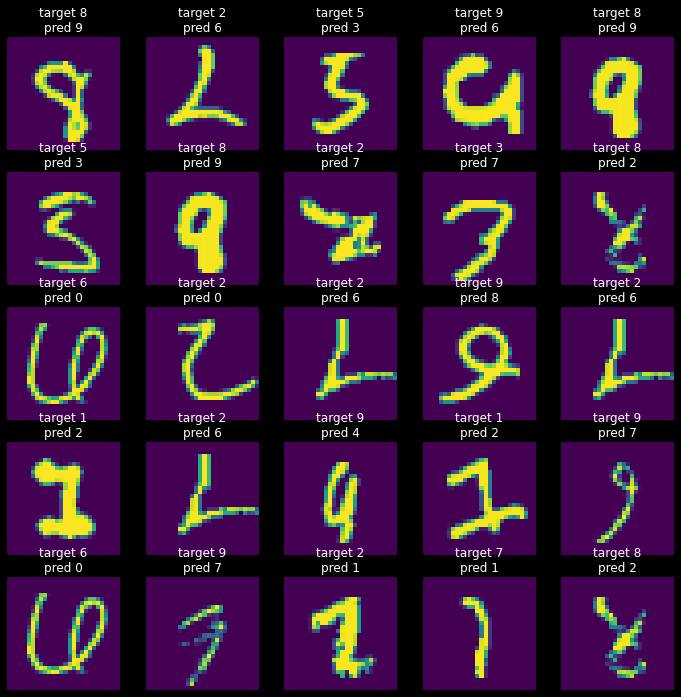

  0%|          | 0/118 [00:00<?, ?it/s]

Approach: Loss, BN =  L1L2 GBN epoch = 1


loss=0.23107244074344635 batch_id=117 Train Accuracy=78.55: 100%|██████████| 118/118 [00:11<00:00, 10.03it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.1123, Test Accuracy: 9737/10000 (97.37%)

Approach: Loss, BN =  L1L2 GBN epoch = 2


loss=0.23866687715053558 batch_id=117 Train Accuracy=95.63: 100%|██████████| 118/118 [00:11<00:00, 10.18it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0636, Test Accuracy: 9823/10000 (98.23%)

Approach: Loss, BN =  L1L2 GBN epoch = 3


loss=0.18982736766338348 batch_id=117 Train Accuracy=96.78: 100%|██████████| 118/118 [00:11<00:00, 10.30it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0500, Test Accuracy: 9860/10000 (98.60%)

Approach: Loss, BN =  L1L2 GBN epoch = 4


loss=0.09896625578403473 batch_id=117 Train Accuracy=97.15: 100%|██████████| 118/118 [00:11<00:00, 10.13it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0462, Test Accuracy: 9872/10000 (98.72%)

Approach: Loss, BN =  L1L2 GBN epoch = 5


loss=0.09378693997859955 batch_id=117 Train Accuracy=97.52: 100%|██████████| 118/118 [00:11<00:00, 10.11it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0375, Test Accuracy: 9894/10000 (98.94%)

Approach: Loss, BN =  L1L2 GBN epoch = 6


loss=0.07351352274417877 batch_id=117 Train Accuracy=97.70: 100%|██████████| 118/118 [00:11<00:00, 10.05it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0376, Test Accuracy: 9883/10000 (98.83%)

Approach: Loss, BN =  L1L2 GBN epoch = 7


loss=0.06261307001113892 batch_id=117 Train Accuracy=97.91: 100%|██████████| 118/118 [00:11<00:00, 10.01it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Test Accuracy: 9915/10000 (99.15%)

Approach: Loss, BN =  L1L2 GBN epoch = 8


loss=0.05799790844321251 batch_id=117 Train Accuracy=98.11: 100%|██████████| 118/118 [00:11<00:00, 10.19it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Test Accuracy: 9912/10000 (99.12%)

Approach: Loss, BN =  L1L2 GBN epoch = 9


loss=0.06739656627178192 batch_id=117 Train Accuracy=98.11: 100%|██████████| 118/118 [00:11<00:00, 10.05it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Test Accuracy: 9916/10000 (99.16%)

Approach: Loss, BN =  L1L2 GBN epoch = 10


loss=0.04247921705245972 batch_id=117 Train Accuracy=98.24: 100%|██████████| 118/118 [00:11<00:00, 10.15it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Test Accuracy: 9913/10000 (99.13%)

Approach: Loss, BN =  L1L2 GBN epoch = 11


loss=0.07507313787937164 batch_id=117 Train Accuracy=98.22: 100%|██████████| 118/118 [00:11<00:00, 10.17it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Test Accuracy: 9920/10000 (99.20%)

Approach: Loss, BN =  L1L2 GBN epoch = 12


loss=0.047184161841869354 batch_id=117 Train Accuracy=98.22: 100%|██████████| 118/118 [00:11<00:00, 10.15it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Test Accuracy: 9920/10000 (99.20%)

Approach: Loss, BN =  L1L2 GBN epoch = 13


loss=0.09537750482559204 batch_id=117 Train Accuracy=98.19: 100%|██████████| 118/118 [00:11<00:00, 10.05it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Test Accuracy: 9916/10000 (99.16%)

Approach: Loss, BN =  L1L2 GBN epoch = 14


loss=0.06424667686223984 batch_id=117 Train Accuracy=98.30: 100%|██████████| 118/118 [00:11<00:00, 10.18it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Test Accuracy: 9920/10000 (99.20%)

Approach: Loss, BN =  L1L2 GBN epoch = 15


loss=0.10035780817270279 batch_id=117 Train Accuracy=98.21: 100%|██████████| 118/118 [00:11<00:00, 10.27it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Test Accuracy: 9918/10000 (99.18%)

Approach: Loss, BN =  L1L2 GBN epoch = 16


loss=0.08316715061664581 batch_id=117 Train Accuracy=98.24: 100%|██████████| 118/118 [00:11<00:00, 10.22it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Test Accuracy: 9916/10000 (99.16%)

Approach: Loss, BN =  L1L2 GBN epoch = 17


loss=0.08263342827558517 batch_id=117 Train Accuracy=98.20: 100%|██████████| 118/118 [00:11<00:00, 10.16it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Test Accuracy: 9918/10000 (99.18%)

Approach: Loss, BN =  L1L2 GBN epoch = 18


loss=0.06014908850193024 batch_id=117 Train Accuracy=98.28: 100%|██████████| 118/118 [00:11<00:00, 10.16it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Test Accuracy: 9917/10000 (99.17%)

Approach: Loss, BN =  L1L2 GBN epoch = 19


loss=0.0332847498357296 batch_id=117 Train Accuracy=98.29: 100%|██████████| 118/118 [00:11<00:00, 10.43it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Test Accuracy: 9918/10000 (99.18%)

Approach: Loss, BN =  L1L2 GBN epoch = 20


loss=0.09423951059579849 batch_id=117 Train Accuracy=98.33: 100%|██████████| 118/118 [00:11<00:00, 10.42it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Test Accuracy: 9918/10000 (99.18%)

Approach: Loss, BN =  L1L2 GBN epoch = 21


loss=0.14064271748065948 batch_id=117 Train Accuracy=98.22: 100%|██████████| 118/118 [00:11<00:00, 10.51it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Test Accuracy: 9920/10000 (99.20%)

Approach: Loss, BN =  L1L2 GBN epoch = 22


loss=0.0651528388261795 batch_id=117 Train Accuracy=98.31: 100%|██████████| 118/118 [00:11<00:00, 10.65it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Test Accuracy: 9918/10000 (99.18%)

Approach: Loss, BN =  L1L2 GBN epoch = 23


loss=0.09942738711833954 batch_id=117 Train Accuracy=98.33: 100%|██████████| 118/118 [00:11<00:00, 10.49it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Test Accuracy: 9919/10000 (99.19%)

Approach: Loss, BN =  L1L2 GBN epoch = 24


loss=0.06602192670106888 batch_id=117 Train Accuracy=98.29: 100%|██████████| 118/118 [00:11<00:00, 10.33it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Test Accuracy: 9918/10000 (99.18%)

Approach: Loss, BN =  L1L2 GBN epoch = 25


loss=0.05011240020394325 batch_id=117 Train Accuracy=98.34: 100%|██████████| 118/118 [00:11<00:00, 10.21it/s]



Test set: Average loss: 0.0264, Test Accuracy: 9918/10000 (99.18%)



In [10]:
from torch.optim.lr_scheduler import StepLR
import pickle, os


# with L1 + BN
# with L2 + BN
# with L1 and L2 with BN
# with GBN
# with L1 and L2 with GBN 
approach_options = [["nll", "BN"],["L1", "BN"], ["L2", "BN"], ["L1L2", "BN"], ["nll", "GBN"], ["L1L2", "GBN"]]
# approach_options = [["nll", "GBN"], ["L1", "BN"], ["L2", "BN"], ["L1L2", "BN"],  ["L1L2", "GBN"]]
approach_dicts = {}
gbn_misclassified = []
gbn_predictions = []
overwrite = True

for approach in approach_options:
  train_losses = []
  test_losses = []
  train_acc = []
  test_acc = []

  # print ("approach = ", approach)
  label = approach[0] + ' with ' + approach[1]
  if (overwrite == False) and os.path.isfile('EVAS6-' + label + '.pkl'):
    with open ('EVAS6-' + label + '.pkl','rb') as f:
      approach_dicts[label] = pickle.load(f)
    #from google.colab import files
    #files.download('EVAS6-' + label + '.pkl')

  else:
    model = Net(approach[1]).to(device) # move the model to device.
    if (approach[0] == "L2") or (approach[0] == "L1L2"):
      optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-5)  # intiating the SGD optimizer
    else:
      optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)  # intiating the SGD optimizer

    scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
    approach_dict = {}

    if approach[1] == "GBN":
      batch_size = 512
      num_splits = 4   
    else:
      batch_size = 128
      num_splits = 2 
      #train_loader.batch_size = 512
      #test_loader.batch_size = 512
      # dataloader arguments - something you'll fetch these from cmdprmt
    dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True) if use_cuda else dict(shuffle=True, batch_size=int(batch_size/2))

    # load the training data and perform standard normalization 
    # parameter for normalization is mean and std dev.
    # train dataloader
    train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

    # test dataloader
    test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

    for epoch in range(1, 26):
        print("Approach: Loss, BN = ",approach[0], approach[1],"epoch =", epoch)
        train(model, device, train_loader, optimizer, epoch, approach[0])
        scheduler.step()
        test(model, device, test_loader)
    
    approach_dict["train_losses"] = train_losses
    approach_dict["train_acc"] = train_acc
    approach_dict["test_losses"] = test_losses
    approach_dict["test_acc"] = test_acc
    approach_dicts[label] = approach_dict
    val_data = {'test_acc':test_acc,'test_losses':test_losses}
    if (overwrite == True) and os.path.exists('EVAS6-' + label + '.pkl'):
        os.remove('EVAS6-' + label + '.pkl') #this deletes the file
    with open('EVAS6-' + label + '.pkl','wb') as f:
      pickle.dump(val_data,f)
  if (approach[0] == "nll") and (approach[1] == "GBN"):
    #gbn_misclassified, _, gbn_predictions = find_missclassified(model)
    Plot_misclassifed(model, device, test_loader)



In [11]:
#%matplotlib inline
#import matplotlib.pyplot as plt

#fig, axs = plt.subplots(2,2,figsize=(15,10))
#axs[0, 0].plot(train_losses)
#axs[0, 0].set_title("Training Loss")
#axs[1, 0].plot(train_acc)
#axs[1, 0].set_title("Training Accuracy")
#axs[0, 1].plot(test_losses)
#axs[0, 1].set_title("Test Loss")
#axs[1, 1].plot(test_acc)
#axs[1, 1].set_title("Test Accuracy")

# Validation Accuracy

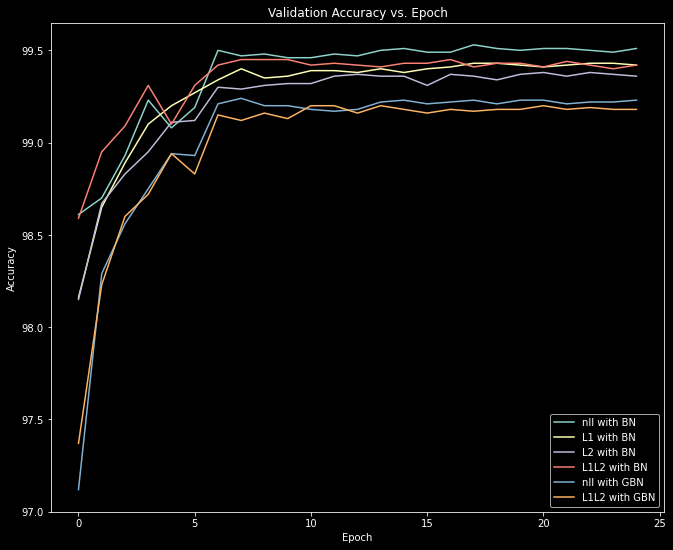

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
plt.style.use("dark_background")
fig = plt.figure(figsize=(11, 9))


for label, approach_dict in approach_dicts.items():
  plt.plot(approach_dict['test_acc'],label = label)


plt.title('Validation Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
if os.path.exists('evas6-acc.png'):
    os.remove('evas6-acc.png') #this deletes the file
fig.savefig('evas6-acc.png',dpi=150)
plt.show()

from google.colab import files
files.download('evas6-acc.png')


# Test Loss

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

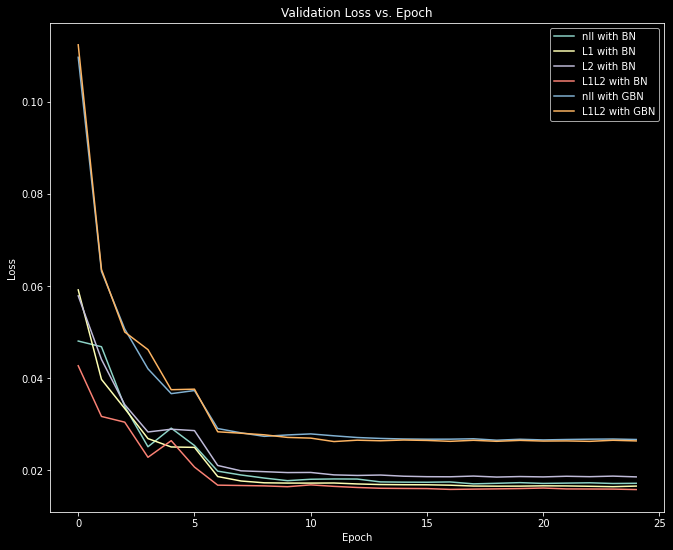

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("dark_background")
fig = plt.figure(figsize=(11, 9))
from google.colab import files

for label, approach_dict in approach_dicts.items():
  plt.plot(approach_dict['test_losses'],label = label)
  files.download('EVAS6-' + label + '.pkl')


plt.title('Validation Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
fig.savefig('evas6-loss.png',dpi=150)
files.download('evas6-loss.png')
